# Unsupervised surgery pipeline with TRVAE

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown
from scipy.sparse import issparse

 captum (see https://github.com/pytorch/captum).


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [4]:
condition_key = 'condition'
cell_type_key = 'cell_label'

trvae_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [5]:
url = "https://drive.google.com/uc?id=1v3-ZmktCS61-oe2v1VtHtIhCeQl78SCN"
output = 'haber_count.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1v3-ZmktCS61-oe2v1VtHtIhCeQl78SCN
To: /Users/chelseaalexandra.bright/haber_count.h5ad
100%|██████████| 34.6M/34.6M [00:01<00:00, 34.0MB/s]


'haber_count.h5ad'

In [6]:
adata = sc.read('haber_count.h5ad')

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [7]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="condition",
    subset=True)

In [8]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


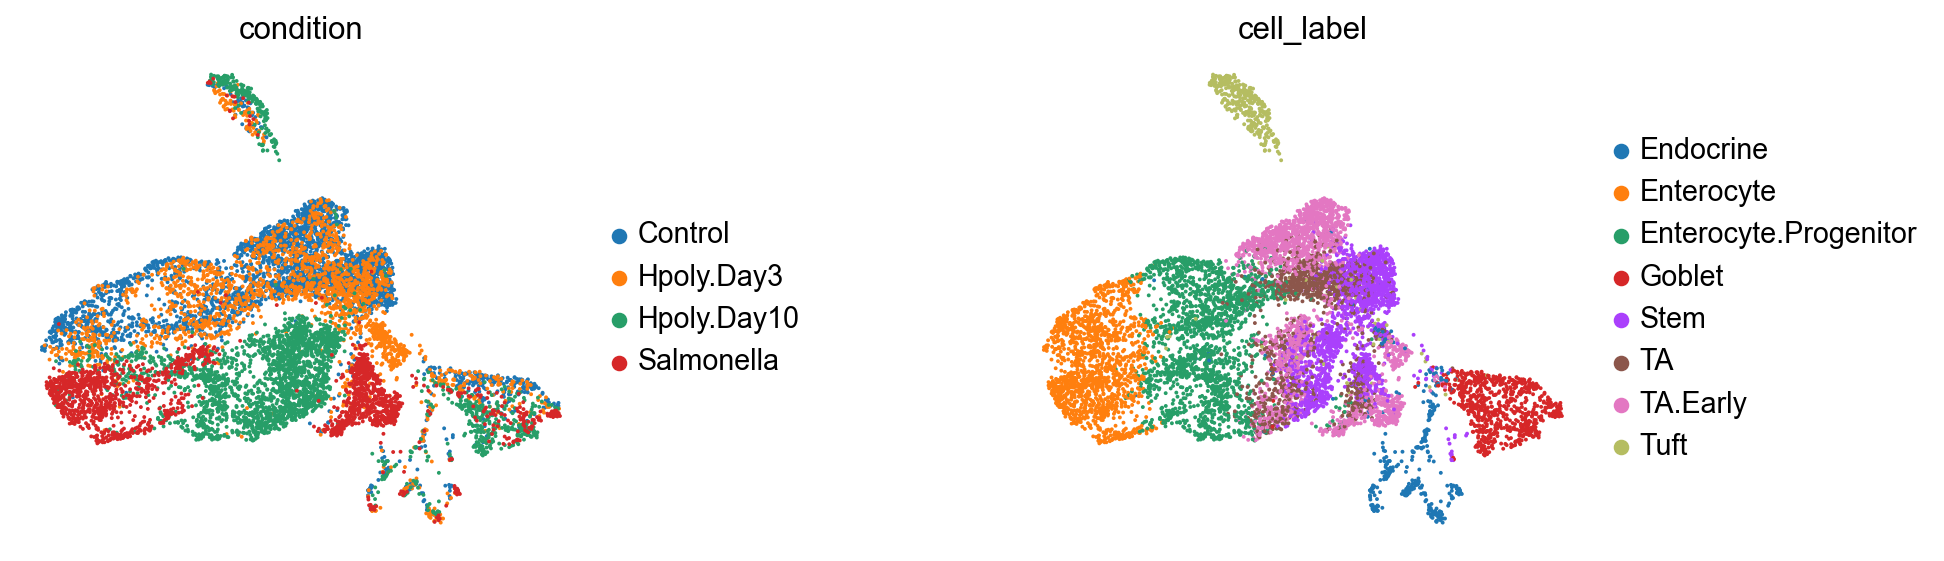

In [9]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], 
           wspace=0.6, 
           frameon=False)

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [10]:
conditions = adata.obs[condition_key].unique().tolist()

In [11]:
trvae = sca.models.TRVAE(
    adata=adata,
    condition_key=condition_key,
    conditions=conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 4
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 4
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [12]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

Preparing (9842, 2000)
Instantiating dataset
 |██████--------------| 33.2%  - val_loss: 369.0865325928 - val_recon_loss: 359.1846008301 - val_kl_loss: 5.9656756520 - val_mmd_loss: 4.98025131231
ADJUSTED LR
 |████████------------| 42.2%  - val_loss: 368.9075355530 - val_recon_loss: 358.5807533264 - val_kl_loss: 5.5352701545 - val_mmd_loss: 4.7915067673
ADJUSTED LR
 |████████------------| 43.6%  - val_loss: 368.8123855591 - val_recon_loss: 358.1589355469 - val_kl_loss: 5.6557266116 - val_mmd_loss: 4.9977209568
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 196


### Create anndata file of latent representation and compute UMAP

In [13]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_label'] = adata.obs[cell_type_key].tolist()
adata_latent.obs['condition'] = adata.obs[condition_key].tolist()

In [14]:
adata_latent.obs

,cell_label,condition
0,Enterocyte.Progenitor,Control
1,Stem,Control
2,Stem,Control
3,Stem,Control
4,Enterocyte.Progenitor,Control
...,...,...
9837,TA,Salmonella
9838,Enterocyte,Salmonella
9839,Stem,Salmonella
9840,Endocrine,Salmonella


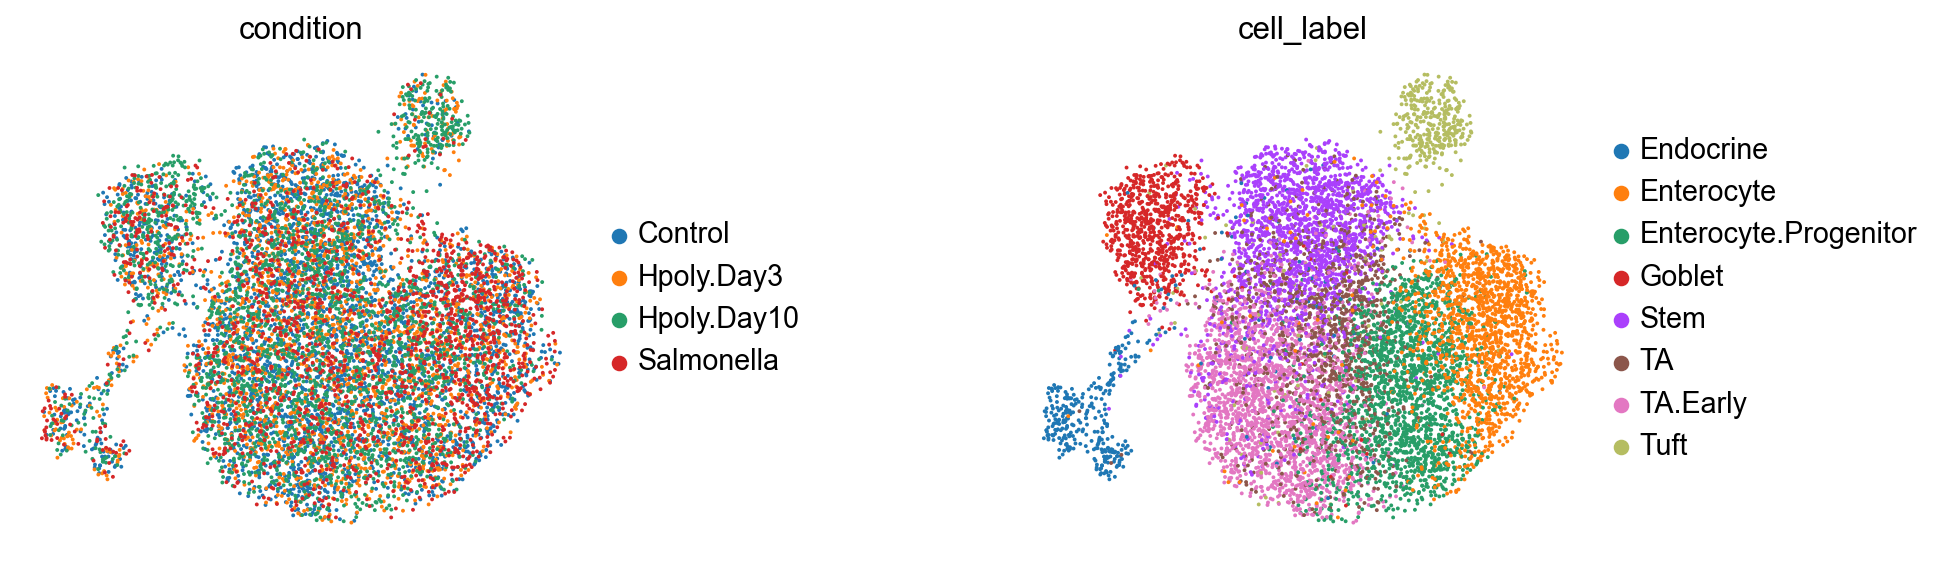

In [15]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['condition', 'cell_label'],
           frameon=False,
           wspace=0.6,
           )

### Get corrected gene expression data

we transfer all conditions to the batch labels with maximum number of samples. 
`target_condition` is the the condtion that you want your  source `adata` be transformed to.

In [16]:
adata_latent.obs[condition_key].value_counts()

condition
Control        3240
Hpoly.Day10    2711
Hpoly.Day3     2121
Salmonella     1770
Name: count, dtype: int64

In [17]:
target_condition = adata_latent.obs[condition_key].value_counts().index[0]

In [18]:
def get_reconstruction(model, x, encoder_labels=None, decoder_labels = None):

    x_ = torch.log(1 + x)
    if model.model.recon_loss == 'mse':
        x_ = x
    
    z_mean, z_log_var = model.model.encoder(x_, encoder_labels)
    latent = model.model.sampling(z_mean, z_log_var)
    output = model.model.decoder(latent, decoder_labels)
    return output[0]

In [19]:
def perturbation_prediction(
    model,
    x=None,
    c=None,
    target_condition=None
    ):    

    device = next(model.model.parameters()).device
    if x is None and c is None:
        x = model.adata.X
        if model.conditions_ is not None:
            c = model.adata.obs[model.condition_key_]

    if c is not None:
        c = np.asarray(c)
        if not set(c).issubset(model.conditions_):
            raise ValueError("Incorrect conditions")
        labels = np.zeros(c.shape[0])
        for condition, label in model.model.condition_encoder.items():
            labels[c == condition] = label
        c = torch.tensor(labels, device=device)

    from scarches.dataset.trvae._utils import label_encoder
    encoder_labels = label_encoder(adata, model.model.condition_encoder, condition_key)
    if target_condition is not None:
        decoder_labels = np.zeros_like(encoder_labels) + model.model.condition_encoder[
            target_condition]
    else:
        decoder_labels = label_encoder(adata, model.model.condition_encoder, condition_key)

    latents = []
    indices = torch.arange(x.shape[0])
    subsampled_indices = indices.split(512)
    for batch in subsampled_indices:
        x_batch = x[batch, :]
        if issparse(x_batch):
            x_batch = x_batch.toarray()
        x_batch = torch.tensor(x_batch, device=device)
        encoder_labels = torch.tensor(encoder_labels, device=device)
        decoder_labels = torch.tensor(decoder_labels, device=device)
        latent = get_reconstruction(model, x_batch, encoder_labels[batch], decoder_labels[batch])
        latents += [latent.cpu().detach()]

    return np.array(torch.cat(latents))

In [20]:
corrected_data = perturbation_prediction(trvae, target_condition=target_condition)

In [21]:
corrected_adata = sc.AnnData(corrected_data)
corrected_adata.obs['cell_label'] = adata.obs[cell_type_key].tolist()
corrected_adata.obs['condition'] = adata.obs[condition_key].tolist()

#### UMAP visualization of corrected gene expression 

In [22]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


As observed  in the corrected gene expression data all samples were mapped to control cells and are mixd now

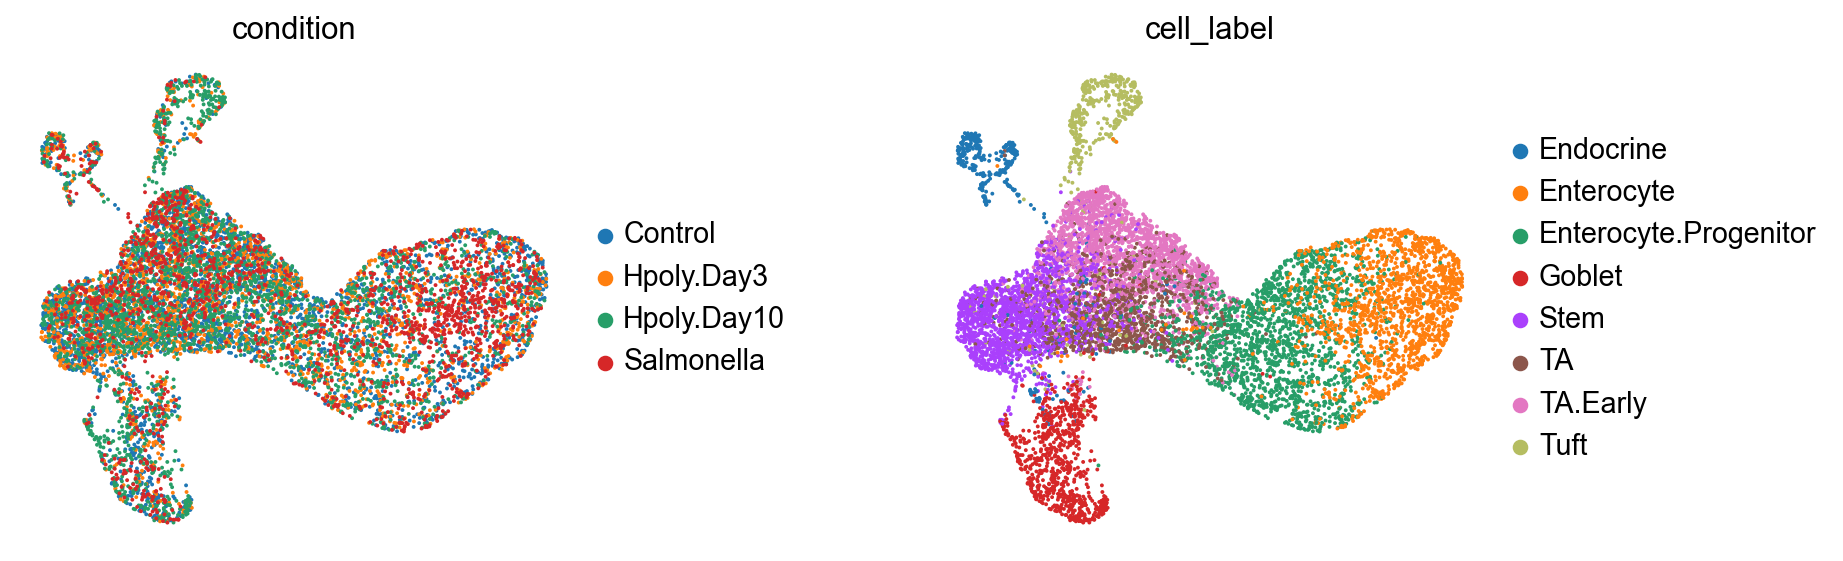

In [23]:
sc.pl.umap(corrected_adata, color=[condition_key, cell_type_key], wspace=0.5, frameon=False)